# FINM 35910 - Homework 3
## Harrison Holt

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import time
from datetime import datetime
import pandas_ta as ta
import ccxt
import seaborn as sn
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import sys
import os
import optuna

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.insert(0, parent_dir)

# from algo_tools import algo_tools as ats
from trading_utils import finm_backtester as fb

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## Data Analysis

In [2]:
df = pd.read_parquet('Data/crypto.parquet')
data = df.loc[df.index >= '2022-01-01']

data = data[['BTC_Close','ETH_Close']].copy()
data = data.rename(columns={'BTC_Close':'close_btc','ETH_Close':'close_eth'})

data['btc_norm'] = (data['close_btc'] - data['close_btc'].mean()) / data['close_btc'].std()
data['eth_norm'] = (data['close_eth'] - data['close_eth'].mean()) / data['close_eth'].std()

train_data = data.loc['2022-01-01':'2024-03-31'].copy()
test_data = data.loc['2024-04-01':'2024-09-30'].copy()

p-value for augmented Engle-Granger test: 0.13010555026949366
Asset p-value for Augmented Dickey-Fuller test: 0.48073817307647815
Spread p-value for Augmented Dickey-Fuller test: 0.8008570526212239
Price ratio p-value for Augmented Dickey-Fuller test: 0.00%


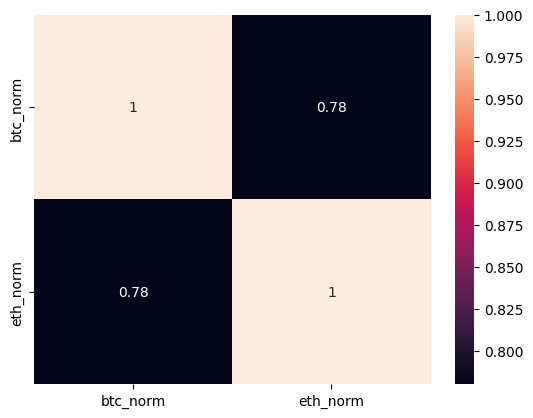

In [28]:
correlation_matrix = test_data[['close_btc','close_eth']].copy().corr()
norm_correlation_matrix = test_data[['btc_norm','eth_norm']].copy().corr()

sn.heatmap(norm_correlation_matrix, annot=True)

asset1 = 'btc_norm'
asset2 = 'eth_norm'

# test_data = data.loc['2024-09-01':].copy()

result = ts.coint(test_data[asset1], test_data[asset2])

print(f"p-value for augmented Engle-Granger test: {result[1]}")
print(f"Asset p-value for Augmented Dickey-Fuller test: {adfuller(test_data[asset2])[1]}")
print(f"Spread p-value for Augmented Dickey-Fuller test: {adfuller(test_data[asset1] - test_data[asset2])[1]}")
print(f"Price ratio p-value for Augmented Dickey-Fuller test: {adfuller(test_data[asset1]/test_data[asset2])[1]:.2%}")

## 1. Define Optimization Goals:
**Clearly outline the objectives of the optimization process, whether it's maximizing profits, minimizing risk, or
achieving a specific risk-adjusted return metric.**

* Our overall objective of the optimization process is to maximize the profits, minimize downside risk, and provide alpha over the benchmark. For this strategy our benchmark is defined as buying and holding bitcoin.
* In order to achieve our objective we will:
    * Identify the key parameters in our trading algo
    * Utilize a pruning algorithm to optimize these parameters
    * Analyze the impact of these optimized parameters on our alpha generation by backtesting the optimized paramters in our model

## 2. Identify Parameters:
**Identify the key parameters in your trading algorithm that can be adjusted, such as moving average periods,
entry and exit thresholds, stop-loss levels, and position sizing parameters.**

The key parameters we can adjust include: 
* Entry Thresholds
* Exit Thresholds
* Rolling Window for of the Z-score of the price ratio

Our alpha signal will be extremely sensitive to any adjustment in the entry and exit thresholds. As a result, optimizing these parameters on a objective function is crucial for our algo to perform optimally. Additionally, the rolling window for the Z-score of the price ratio will define the key indicator driving whether we buy or sell. 

## 3. Set Parameter Ranges:
**Define the ranges or constraints for each parameter. Determine the minimum, maximum, and step size for
numerical parameters, ensuring a reasonable and practical range.**


Given the nature of our trading algo, we can intuitively select broad ranges for the different paramters, however, we will define fairly wide ranges for the intial tuning.

For the entry thresholds, we want the Z-score to be moderately high enough to indicate a significant deviation between the two asset prices. Similarly, for the exit threshold the z-score needs to be near zero to indicate the prices have returned back to their mean ratio.

* Rolling Window: [20, 120] days (increment by 1 day).
* Entry Threshold: [1.0, 3.0] (increment by 0.1).
* Exit Threshold: [0.1, 1.0] (increment by 0.1).

## 4. Choose an Optimization Method:
**Select an optimization method such as grid search, random search, regime switch, genetic algorithms,
simulated annealing, Bayesian optimization, or even a custom method.
(Consider the complexity of your strategy and the computational resources available when choosing the appropriate optimization
method.)**

We selected Optuna as our optimization method due to its flexiblity and ability to handle a number of paramters through Bayesian optimization. Furthermore, Optuna's pruning features terminate early results that seem unlikely to improve results. 

Additionally we defined maximizing the Sortino Ratio as our objective function. The Sortino Ratio is a metric used to measure the excess return of a portfolio, focusing on downside risk rather than overall volatility. We choose this as our objective metric because it differentiates between negative and positive volatility. As a result, Optuna will optimize for risk adjusted returns only penalizing for downside risk.

## 5. Perform Optimization:
**Apply the chosen optimization method to systematically test parameters or a different combination of
parameters within the defined ranges.
Evaluate the strategy's performance based on predefined metrics, considering both in-sample and out-ofsample data, and execute again if necessary.**

As explained above, we applied a pruning algorithm utilizing Bayesian optimization to optimize the key parameters of our strategy for Sortino Ratio.

In order to evaluate the impact of these parameters on our strategy's performance, we backtested our strategy on a training and test dataset. The training backtest performed strongly, however, underperformed the benchmark in key metrics including annualized mean return, sharp ratio, and sortino ratio. Additionally, for the test set we saw similar results.

In [4]:
# Assuming pairs_trading_strategy is already defined
def pairs_trading_strategy(df, entry_threshold=2, exit_threshold=0.5, rolling_window=60):
    data = df.copy()
    data['btc_norm'] = (data['close_btc'] - data['close_btc'].mean()) / data['close_btc'].std()
    data['eth_norm'] = (data['close_eth'] - data['close_eth'].mean()) / data['close_eth'].std()
    data['price_ratio'] = data['btc_norm'] / data['eth_norm']
    
    data['z_score'] = (data['price_ratio'] - data['price_ratio'].rolling(window=rolling_window).mean()) / data['price_ratio'].rolling(window=rolling_window).std()
    
    data['signal'] = 0 
    data.loc[data['z_score'] > entry_threshold, 'signal'] = -1 # Short signal (sell BTC, buy ETH)
    data.loc[data['z_score'] < -entry_threshold, 'signal'] = 1 # Long signal (buy BTC, sell ETH)
    data.loc[data['z_score'].abs() < exit_threshold, 'signal'] = 0 # Exit signal
    data['signal'] = data['signal'].shift(1)
    return data

def compute_sharpe_ratio(df, signals, risk_free_rate=0.0):
    """Calculate Sharpe Ratio for given signals."""
    df['strategy_returns'] = signals.shift(1) * df['close_btc'].pct_change()  # Example: Returns from BTC price changes
    strategy_returns = df['strategy_returns'].dropna()
    excess_returns = strategy_returns  # Assuming daily data (252 trading days per year)
    sortino_ratio = (np.mean(excess_returns)*(60*24*252)) / (np.std(excess_returns[excess_returns<0])*np.sqrt(60*24*252))
    return sortino_ratio

def objective(trial, df):
    """Objective function for hyperparameter optimization."""
    # Suggest parameters
    entry_threshold = trial.suggest_float('entry_threshold', 1.0, 3.0, step=0.1)
    exit_threshold = trial.suggest_float('exit_threshold', 0.1, 1.0, step=0.1)
    rolling_window = trial.suggest_int('rolling_window', 20, 120)

    # Apply the strategy
    strategy_df = pairs_trading_strategy(df, entry_threshold, exit_threshold, rolling_window)
    
    # Calculate Sharpe Ratio
    sharpe_ratio = compute_sharpe_ratio(strategy_df, strategy_df['signal'])
    
    return -sharpe_ratio  # Minimize negative Sharpe Ratio

In [31]:

# Example: Run optimization
def optimize_strategy(df, n_trials=100):
    """Optimize the pairs trading strategy using Optuna."""
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, df), n_trials=n_trials)
    return study

# Run the optimization
study = optimize_strategy(train_data,100)

# Best parameters and results
print("Best Parameters:", study.best_params)
print("Best Sharpe Ratio:", -study.best_value)

[I 2024-11-22 23:34:02,460] A new study created in memory with name: no-name-b2af420d-8c7a-417d-84a6-366f705e0230
[I 2024-11-22 23:34:02,709] Trial 0 finished with value: -0.5223962543447143 and parameters: {'entry_threshold': 1.2, 'exit_threshold': 0.6, 'rolling_window': 106}. Best is trial 0 with value: -0.5223962543447143.
[I 2024-11-22 23:34:02,857] Trial 1 finished with value: -0.3074894268904375 and parameters: {'entry_threshold': 1.6, 'exit_threshold': 1.0, 'rolling_window': 112}. Best is trial 1 with value: -0.3074894268904375.
[I 2024-11-22 23:34:02,990] Trial 2 finished with value: 0.05640686441218224 and parameters: {'entry_threshold': 2.4000000000000004, 'exit_threshold': 0.30000000000000004, 'rolling_window': 64}. Best is trial 2 with value: 0.05640686441218224.
[I 2024-11-22 23:34:03,124] Trial 3 finished with value: 0.02331979682077078 and parameters: {'entry_threshold': 1.8, 'exit_threshold': 0.1, 'rolling_window': 42}. Best is trial 2 with value: 0.05640686441218224.
[

Best Parameters: {'entry_threshold': 3.0, 'exit_threshold': 0.4, 'rolling_window': 89}
Best Sharpe Ratio: -0.14965744562618497


In [32]:
optuna.visualization.plot_optimization_history(study)

In [34]:
study.best_params

{'entry_threshold': 3.0, 'exit_threshold': 0.4, 'rolling_window': 89}

In [5]:
train_results = pairs_trading_strategy(train_data, entry_threshold=3.0, exit_threshold=0.4, rolling_window=89)
test_results = pairs_trading_strategy(test_data, entry_threshold=3.0, exit_threshold=0.4, rolling_window=89)

In [8]:
train_sim = fb.BacktestSim(train_results['close_btc'], train_results['signal'], initial_cash=1_000_000, transaction_cost=0.000)
train_sim.run()

Running backtest simulation...
Buying 21.0 shares at price 47162.4
Selling 21.0 shares at price 47627.0
Buying 21.0 shares at price 46963.4
Selling 21.0 shares at price 47519.5
Buying 22.0 shares at price 45817.0
Selling 22.0 shares at price 46398.8
Buying 22.0 shares at price 46700.0
Selling 22.0 shares at price 47383.9
Buying 22.0 shares at price 46549.4
Selling 22.0 shares at price 46620.9
Buying 22.0 shares at price 46368.9
Selling 22.0 shares at price 46601.9
Buying 22.0 shares at price 46130.9
Selling 22.0 shares at price 43626.9
Buying 23.0 shares at price 43062.0
Selling 23.0 shares at price 43313.5
Buying 23.0 shares at price 42255.4
Selling 23.0 shares at price 42245.5
Buying 24.0 shares at price 41662.6
Selling 24.0 shares at price 41657.6
Buying 24.0 shares at price 41421.3
Selling 24.0 shares at price 41925.1
Buying 24.0 shares at price 42016.1
Selling 24.0 shares at price 41886.0
Buying 24.0 shares at price 41555.9
Selling 24.0 shares at price 42467.7
Buying 24.0 shares a

,action,positions,cash,transaction_fees,position_values,portfolio_values,cumulative_pnl
date,,,,,,,
2022-01-01 00:00:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
2022-01-01 00:01:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
2022-01-01 00:02:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
2022-01-01 00:03:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
2022-01-01 00:05:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
...,...,...,...,...,...,...,...
2024-03-31 23:53:00+00:00,HOLD,0.0,1180564.5,0.0,0.0,1180564.5,180564.5
2024-03-31 23:54:00+00:00,HOLD,0.0,1180564.5,0.0,0.0,1180564.5,180564.5
2024-03-31 23:55:00+00:00,HOLD,0.0,1180564.5,0.0,0.0,1180564.5,180564.5


In [6]:
test_sim = fb.BacktestSim(test_results['close_btc'], test_results['signal'], initial_cash=1_000_000, transaction_cost=0.000)
test_sim.run()

Running backtest simulation...
Buying 14.0 shares at price 70618.8
Selling 14.0 shares at price 70399.5
Buying 14.0 shares at price 69250.5
Selling 14.0 shares at price 68707.5
Buying 14.0 shares at price 69500.0
Selling 14.0 shares at price 66060.6
Buying 14.0 shares at price 66192.8
Selling 14.0 shares at price 66732.0
Buying 14.0 shares at price 65900.4
Selling 14.0 shares at price 65800.0
Buying 14.0 shares at price 65900.0
Selling 14.0 shares at price 65874.7
Buying 14.0 shares at price 65146.5
Selling 14.0 shares at price 66035.8
Buying 14.0 shares at price 66174.7
Selling 14.0 shares at price 68660.6
Buying 14.0 shares at price 67575.1
Selling 14.0 shares at price 68217.2
Buying 14.0 shares at price 69101.0
Selling 14.0 shares at price 69549.9
Buying 14.0 shares at price 71300.1
Selling 14.0 shares at price 71240.0
Buying 14.0 shares at price 70705.1
Selling 14.0 shares at price 68794.0
Buying 13.0 shares at price 70996.9
Selling 13.0 shares at price 70675.1
Buying 13.0 shares a

,action,positions,cash,transaction_fees,position_values,portfolio_values,cumulative_pnl
date,,,,,,,
2024-04-01 00:00:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
2024-04-01 00:01:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
2024-04-01 00:02:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
2024-04-01 00:03:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
2024-04-01 00:04:00+00:00,HOLD,0.0,1000000.0,0.0,0.0,1000000.0,0.0
...,...,...,...,...,...,...,...
2024-09-30 23:53:00+00:00,HOLD,0.0,828875.1,0.0,0.0,828875.1,-171124.9
2024-09-30 23:54:00+00:00,HOLD,0.0,828875.1,0.0,0.0,828875.1,-171124.9
2024-09-30 23:55:00+00:00,HOLD,0.0,828875.1,0.0,0.0,828875.1,-171124.9


In [20]:
adj = 60*24*365
print("Strategy - Training Set")
display(train_sim.calculate_metrics(adj=adj))
print("Benchmark - Training Set")
display(train_sim.calculate_metrics(adj=adj, benchmark=True))
print("Strategy - Test Set")
display(test_sim.calculate_metrics(adj=adj))
print("Benchmark - Test Set")
display(test_sim.calculate_metrics(adj=adj, benchmark=True))

Strategy - Training Set


,annualized_mean,annualized_std,sharpe_ratio,sortino_ratio,win_rate,skewness,excess_kurtosis,var_95,cvar_95,min,max,tracking_error,information_ratio,treynor_ratio,jensens_alpha,max_drawdown,peak,bottom
returns,0.206071,0.448453,0.459515,193912.484392,0.268591,0.247083,149.769052,-0.00078,-0.001529,-0.033389,0.044598,0.45481,0.45309,0.417915,0.20607,-0.605091,2022-04-05 17:40:00+00:00,2022-11-14 20:12:00+00:00


Benchmark - Training Set


,annualized_mean,annualized_std,sharpe_ratio,sortino_ratio,win_rate,skewness,excess_kurtosis,var_95,cvar_95,min,max,tracking_error,information_ratio,treynor_ratio,jensens_alpha,max_drawdown,peak,bottom
returns,0.483465,0.644721,0.749883,454999.370032,0.449856,0.131742,63.390456,-0.001246,-0.002114,-0.034403,0.045441,0.0,inf,0,0,-0.678271,2022-03-28 19:33:00+00:00,2022-11-21 21:51:00+00:00


Strategy - Test Set


,annualized_mean,annualized_std,sharpe_ratio,sortino_ratio,win_rate,skewness,excess_kurtosis,var_95,cvar_95,min,max,tracking_error,information_ratio,treynor_ratio,jensens_alpha,max_drawdown,peak,bottom
returns,-0.374156,0.38367,-0.975202,-425621.795507,0.248377,0.036022,125.253714,-0.00072,-0.001352,-0.029015,0.026637,0.363441,-1.02948,-0.711284,-0.374156,-0.242881,2024-06-07 13:51:00+00:00,2024-09-06 21:01:00+00:00


Benchmark - Test Set


,annualized_mean,annualized_std,sharpe_ratio,sortino_ratio,win_rate,skewness,excess_kurtosis,var_95,cvar_95,min,max,tracking_error,information_ratio,treynor_ratio,jensens_alpha,max_drawdown,peak,bottom
returns,-0.134528,0.5388,-0.24968,-146321.418105,0.443785,-0.07718,54.529915,-0.001085,-0.001819,-0.030506,0.028214,0.0,-inf,0,0,-0.320161,2024-04-08 12:11:00+00:00,2024-08-05 06:24:00+00:00


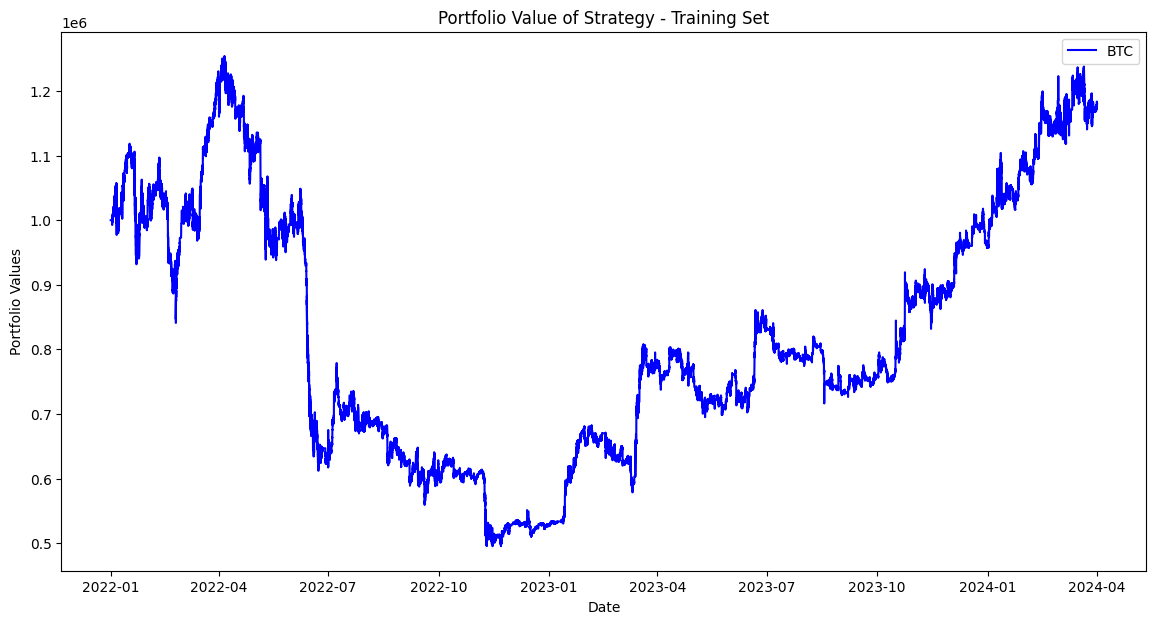

In [14]:
plot_df = train_sim.portfolio

plt.figure(figsize=(14,7))
plt.plot(plot_df.index, plot_df['portfolio_values'], label='BTC', color='blue')
plt.title(f"Portfolio Value of Strategy - Training Set")
plt.xlabel('Date')
plt.ylabel('Portfolio Values')
plt.legend()
plt.show()

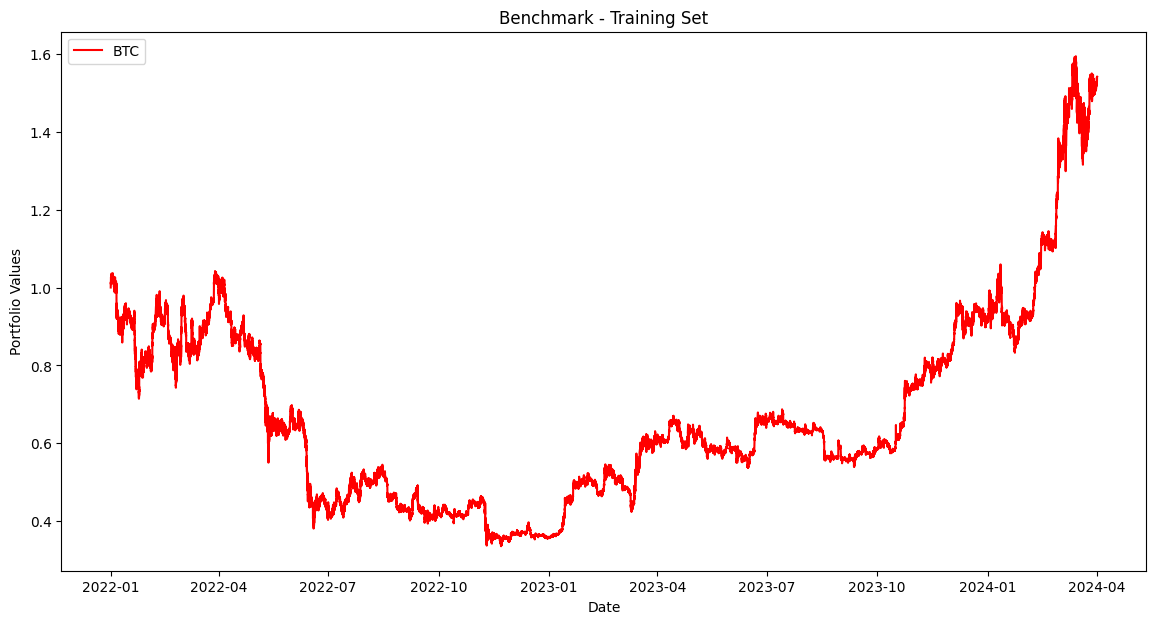

In [25]:
plot_df = (1+train_sim.close_price.pct_change()).cumprod()

plt.figure(figsize=(14,7))
plt.plot(plot_df.index, plot_df.values, label='BTC', color='red')
plt.title(f"Benchmark - Training Set")
plt.xlabel('Date')
plt.ylabel('Portfolio Values')
plt.legend()
plt.show()

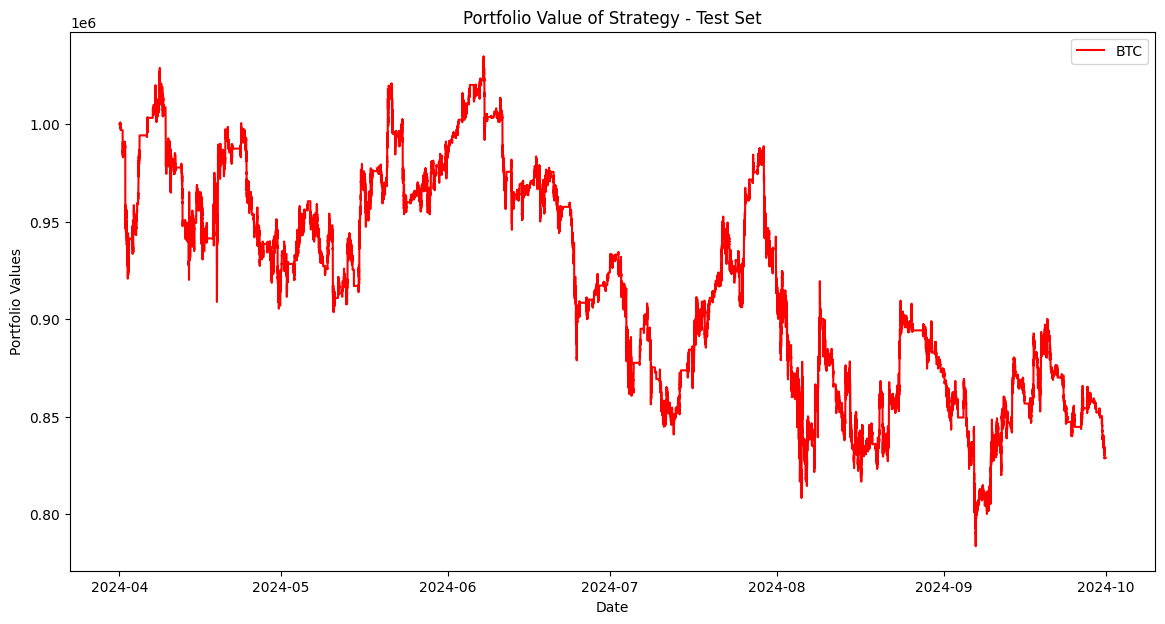

In [ ]:
plot_df = test_sim.portfolio

plt.figure(figsize=(14,7))
plt.plot(plot_df.index, plot_df['portfolio_values'], label='BTC', color='blue')
plt.title(f"Portfolio Value of Strategy - Test Set")
plt.xlabel('Date')
plt.ylabel('Portfolio Values')
plt.legend()
plt.show()

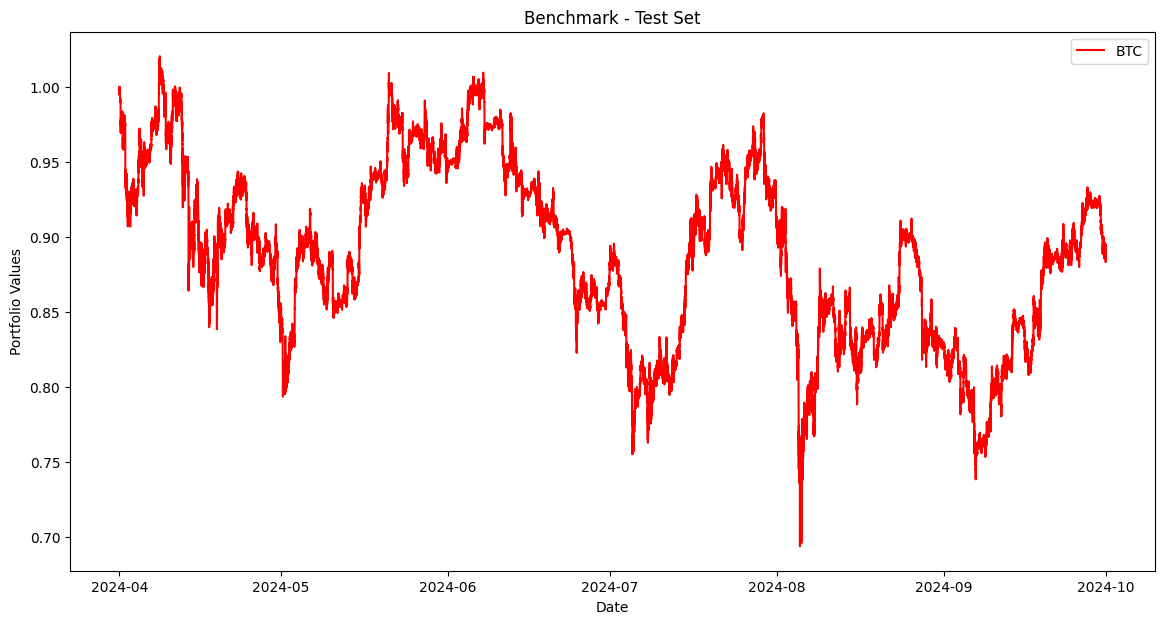

In [27]:
plot_df = (1+test_sim.close_price.pct_change()).cumprod()

plt.figure(figsize=(14,7))
plt.plot(plot_df.index, plot_df.values, label='BTC', color='red')
plt.title(f"Benchmark - Test Set")
plt.xlabel('Date')
plt.ylabel('Portfolio Values')
plt.legend()
plt.show()

## 6. Provide Results:
**Provide the optimization results to identify parameter sets that yield the best performance metrics, such as
highest returns, lowest drawdowns, or optimal risk-adjusted ratios.**

As shown below, the entry threshold proved to be the most important parameter in optimizing for our defined performance metrics. Additionally, after running 100 trials the best parameters for optimizing the Sortino Ratio generated by our strategies performance included:
* Entry Threshold: 3.0
* Exit Threshold: 0.4
* Rolling Window: 89

In [51]:
study.best_params

{'entry_threshold': 3.0, 'exit_threshold': 0.4, 'rolling_window': 89}

In [46]:
optuna.visualization.plot_param_importances(study)